# Visualizing the booking history of the UHCW dataset
## Definitions
The **booking history** refers to the status as "available" or "booked" of the appointments in the dataset at the various data collection times.

The **final status** refers to whether an appointment was eventually booked or went unused.
  


## Imports

In [2]:
import os
import pytz
import pandas as pd
import datetime
import UHCW
import matplotlib.pyplot as plt
%matplotlib inline

14h35m04s: Make copy of data...
14h35m04s: Type conversion: 
14h35m04s: Column appointment:
14h35m04s: Convert to datetime...
14h35m04s: Convert to London timezone...
14h35m05s: Column grab:
14h35m05s: Convert to datetime...
14h35m05s: Localize to UTC and convert to London timezone...
Cartesian product grabs by appointments...
2019-01-15 13:40:00+00:00
2019-01-17 15:30:00+00:00
Ignore grabs past appointments...
Restrict to past appointments...
2019-01-17 15:30:00+00:00
Sort by id, test type, appointment, grab...
Add status...
Add extra grab columns:
14:35:05: grab hour...
14:35:05: grab 3 hours...
14:35:06: grab day...


In [3]:
beg_script = datetime.datetime.now()

## Constants

In [4]:
IMG_DIR = os.path.join(os.path.expanduser("~"), "Projects/UHCW/IMAGE_FILES")

STATUS_TO_VALUE = {'available': 0, 'booked': 1}

## Helper functions

In [5]:
def write_line_to_desc(col, text, file):
    """Convenience function to add one line to a file in a particular format."""
    file.write(
        "{0}{1}{2}\n".format(
            col.ljust(COL_WIDTH),
            VERT_SEP,
            text
        )
    )
def timedelta_strftime(duration):
    """Convenience function to string format a timedelta."""
    string = "{0} days {1} hours {2} minutes".format(
        duration.days,
        duration.seconds//3600,
        duration.seconds//60
    )
    return string

## Data

In [6]:
%%time
print(datetime.datetime.now().strftime("Time: %H:%M:%S"))
foldername = 'Projects/UHCW'
# Choose from among datasets of various sizes (various collection periods or centers)
# filename = 'appointments-tiny.csv'
# filename = 'appointments-less-tiny.csv'
# filename = 'appointments-one-week-two-centers.csv'
filename = 'appointments-24-hours.csv'
# filename = 'appointments-one-week.csv'
# filename = 'appointments-three-weeks.csv'
filepath = os.path.join(os.path.expanduser("~"), foldername, filename)

filesize = os.path.getsize(filepath)
if filesize > 1e9:
    print("Size of data file: {}GB.".format(filesize//1e9))
elif filesize > 1e6:
    print("Size of data file: {}MB.".format(filesize//1e6))
elif filesize > 1e3:
    print("Size of data file: {}KB.".format(filesize//1e3))
else:
    print("Size of data file: {}B.".format(filesize))
print("Loading data...")
raw_data = pd.read_csv(filepath, sep=';')
raw_data.rename(
    index=str,
    columns={
        'center id': 'id',
        'appointment timestamp': 'appointment',
        'center age group': 'age group',
        'grab timestamp': 'grab'
    },
    inplace=True
)

Time: 14:35:07
Size of data file: 291.0MB.
Loading data...
CPU times: user 3.81 s, sys: 457 ms, total: 4.26 s
Wall time: 4.26 s


## The schedule (restricted to shorter grab period)
The dataframe `schedule` is essentially `raw_data` after certain type conversion.  

*(The next cell prints the current time to remember when the following cell was run.)*

In [7]:
print(datetime.datetime.now().strftime("Current time: %Hh %Mm %Ss"))

Current time: 14h 35m 11s


In [8]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5117059 entries, 0 to 5117058
Data columns (total 5 columns):
appointment    object
age group      object
id             int64
test type      object
grab           object
dtypes: int64(1), object(4)
memory usage: 234.2+ MB


In [9]:
%%time

schedule = UHCW.prepare_UHCW_dataframe(raw_data)

14h35m11s: Make copy of data...
14h35m11s: Type conversion: 
14h35m11s: Column appointment:
14h35m11s: Convert to datetime...
14h35m12s: Convert to London timezone...
14h38m12s: Column grab:
14h38m12s: Convert to datetime...
14h38m12s: Localize to UTC and convert to London timezone...
CPU times: user 4min 24s, sys: 3.91 s, total: 4min 28s
Wall time: 4min 26s


In [10]:
print(datetime.datetime.now().strftime("End of preprocessing:  %Hh %Mm %Ss"))

End of preprocessing:  14h 39m 37s


## The working schedule

Only consider past appointments (and ignore "age group" info which we won't use):

In [11]:
last_grab = schedule['grab'].max()
s = schedule.query('appointment <= @last_grab').copy()
s.drop('age group', axis=1, inplace=True)

## Center info

In [12]:
center_test_types = s.groupby('id')['test type'].unique().rename("test types").to_frame()#.reset_index()
center_test_types

,test types
id,
10136,"[Non Fasting Bloods, INR Test]"
10137,[Blood Test]
10188,"[Blood Test, INR Test]"
10207,[Blood Test]
10243,"[Blood Test, INR Test]"
10244,"[Blood Test, INR Test]"
10250,"[Blood Test, INR Test]"
10254,[Blood Test]
10266,[Blood Test]


## Number of appointments

In [13]:
s.groupby(['id', 'test type'])['appointment'].nunique().to_frame()

appointment
id    test type                      
10136 INR Test                      5
      Non Fasting Bloods            5
10137 Blood Test                    1
10188 Blood Test                   35
      INR Test                      5
10207 Blood Test                   34
10243 Blood Test                   24
      INR Test                      8
10244 Blood Test                    1
      INR Test                      1
10250 Blood Test                   30
      INR Test                     20
10254 Blood Test                    1
10266 Blood Test                    1
10336 Blood Test                    2
10352 Blood Test                    2
      INR Test                      2

## The timegrid
The `schedule` contains a row for each appointment available at the times of data collection.
The timegrid gives the status of the appointment as "available" or "booked" at all data collection times.
This is the **booking history** associated with the schedule.
We can also determine whether an appointment was eventually booked or went unused.

In [15]:
t = UHCW.get_timegrid(s)

Cartesian product grabs by appointments...
2019-01-15 13:40:00+00:00
2019-01-16 12:10:00+00:00
Ignore grabs past appointments...
Restrict to past appointments...
2019-01-16 12:10:00+00:00
Sort by id, test type, appointment, grab...
Add status...
Add extra grab columns:
14:39:39: grab hour...
14:39:39: grab 3 hours...
14:39:39: grab day...


## Visualizing the booking history
The following cell plots the booking history for all centers and test types.  

Set `save_figure` to **True** to save plots as image files.
In this case, a brief description of the type of figure is appended to `DESCRIPTION-OF-RUNS.txt`.

10136
Non Fasting Bloods
Remark: no data for status "available"
INR Test
Remark: no data for status "available"
10137
Blood Test
Remark: no data for status "booked"
10188
Blood Test
Remark: no data for status "available"
INR Test
10207
Blood Test
Remark: no data for status "available"
10243
Blood Test
INR Test
10244
Blood Test
Remark: no data for status "booked"
INR Test
Remark: no data for status "booked"
10250
Blood Test
Remark: no data for status "available"
INR Test
Remark: no data for status "available"
10254
Blood Test
10266
Blood Test
Remark: no data for status "booked"
10336
Blood Test
Remark: no data for status "available"
10352
Blood Test
INR Test


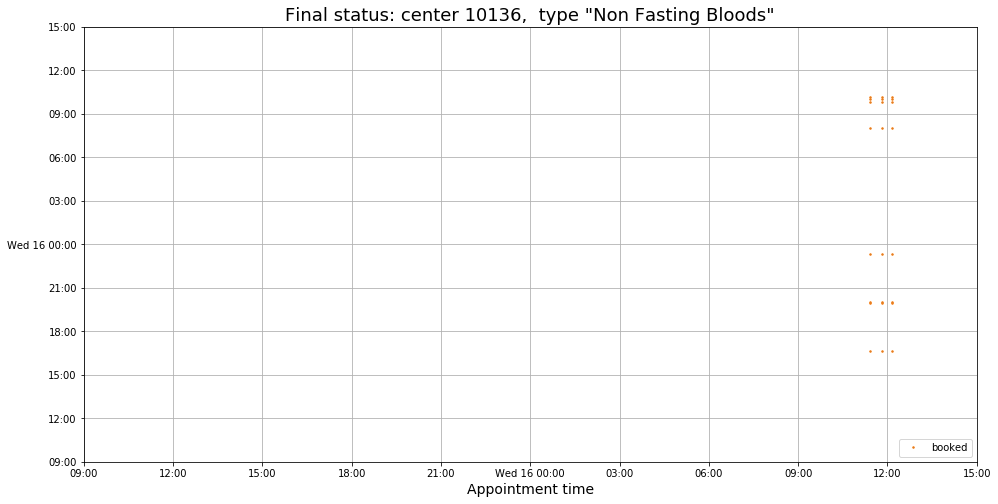

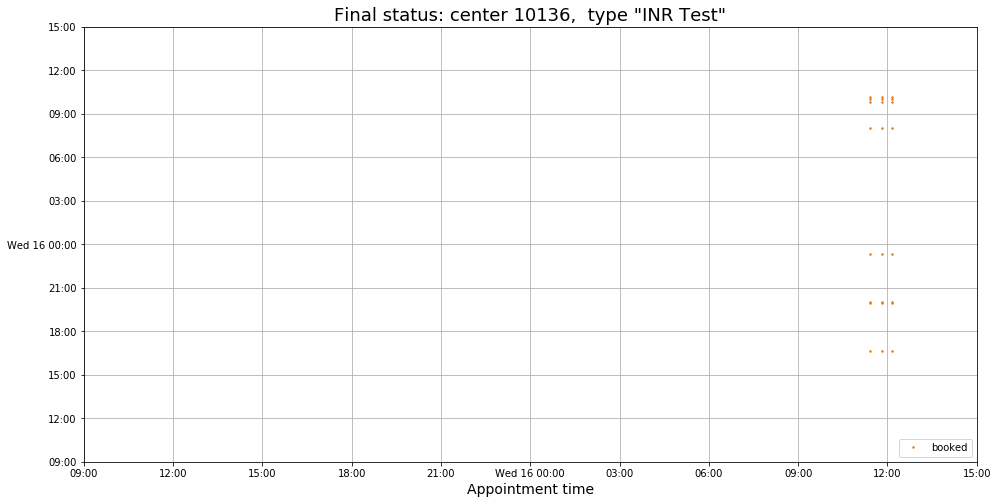

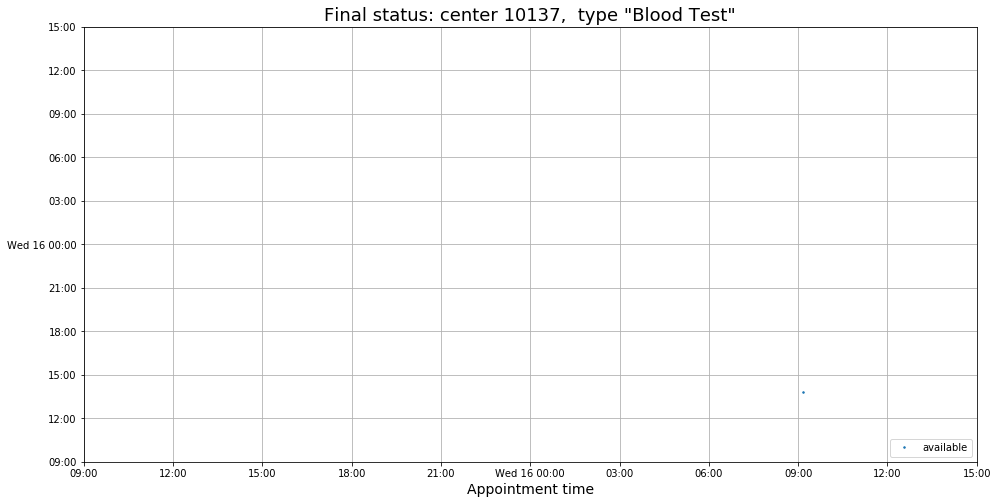

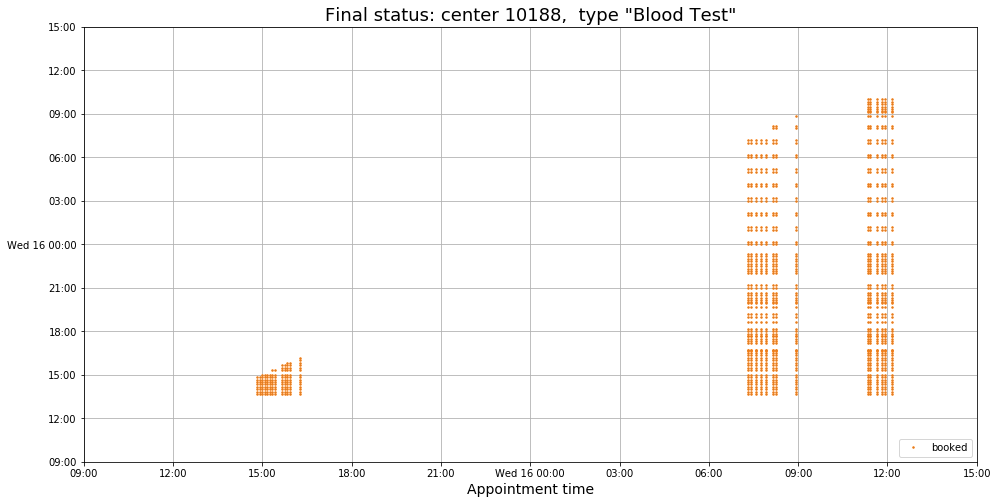

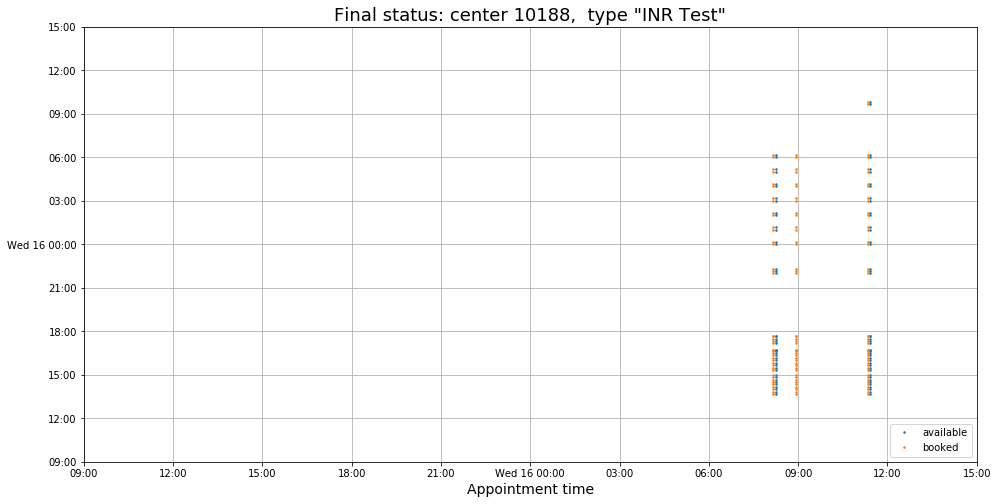

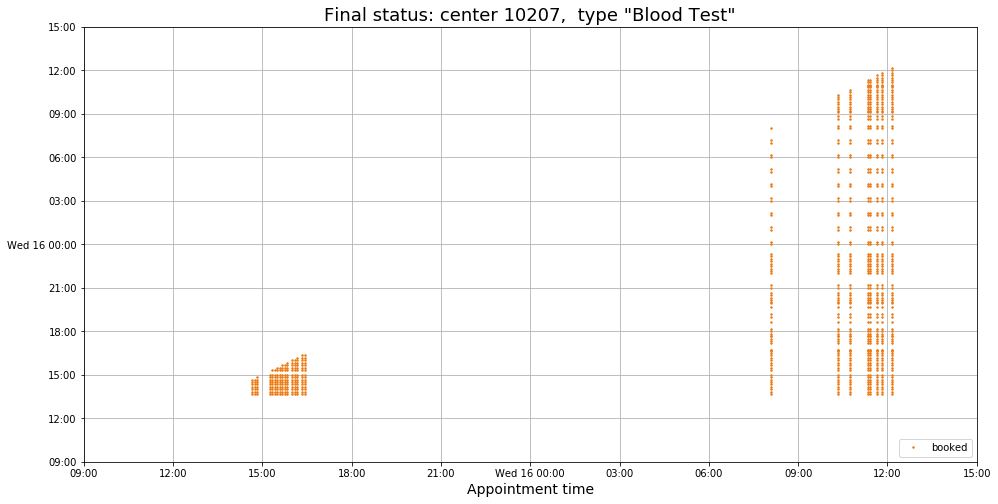

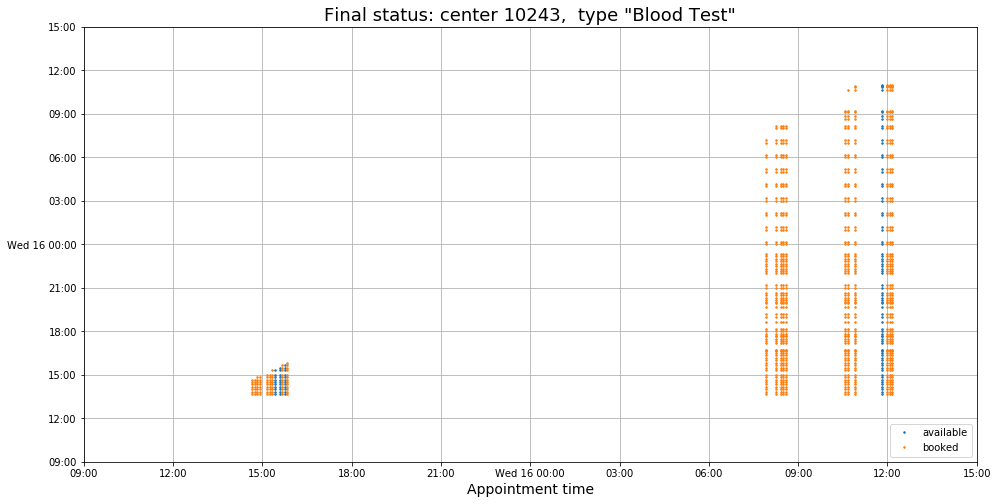

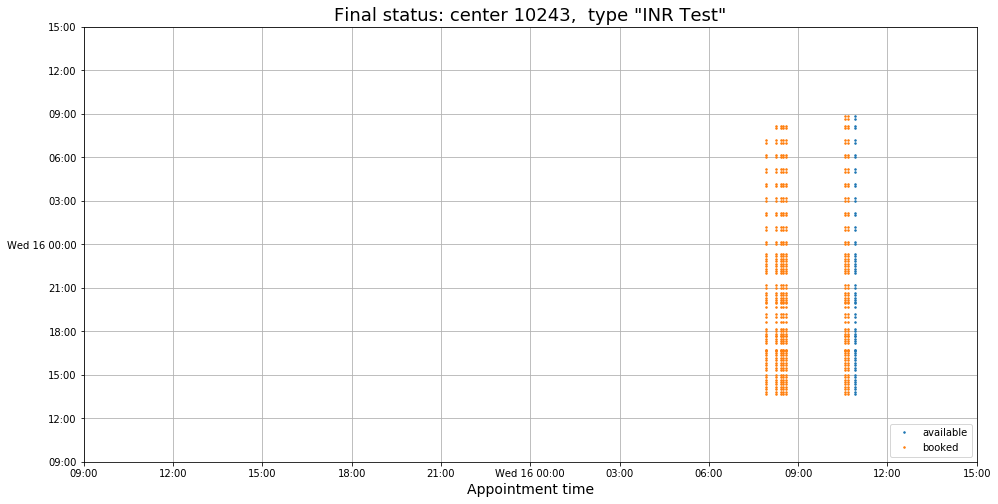

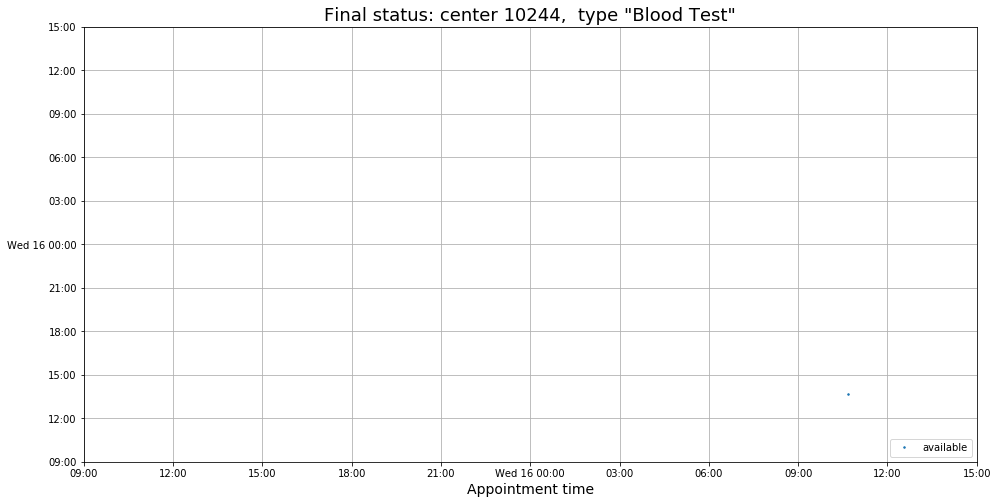

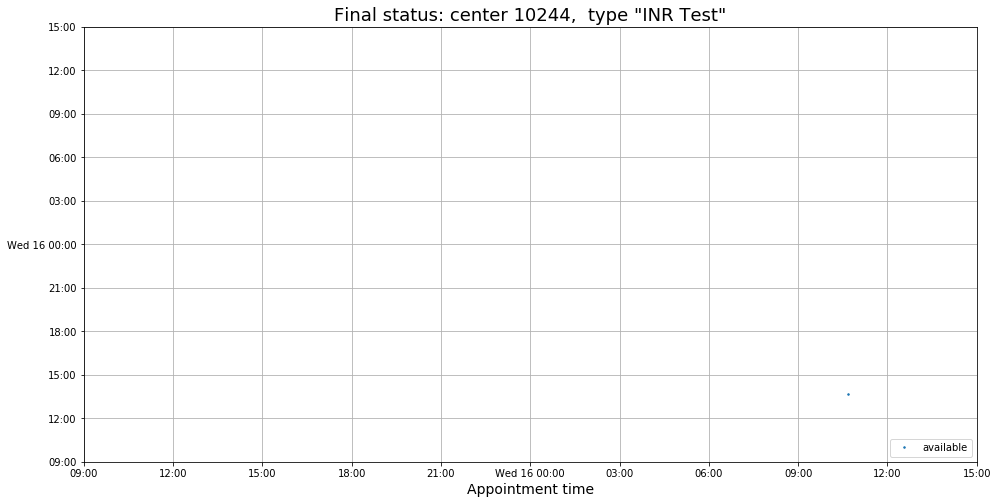

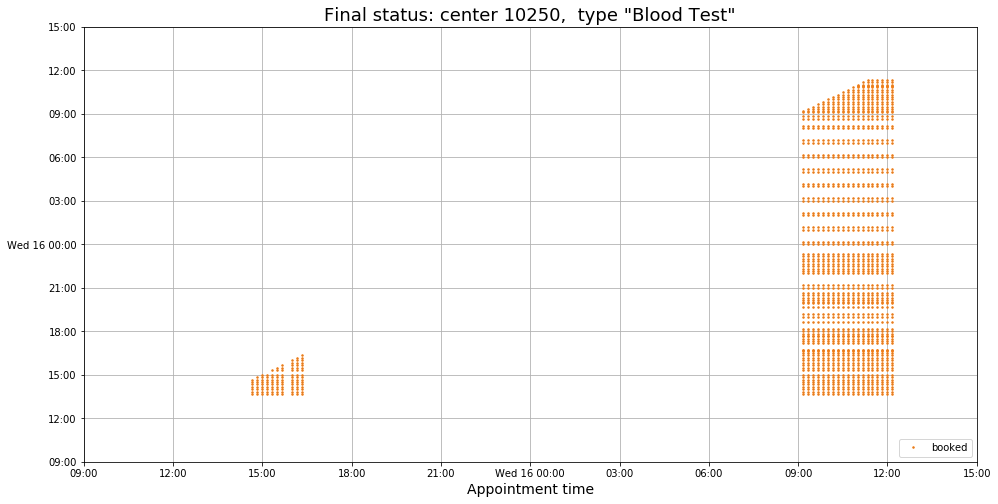

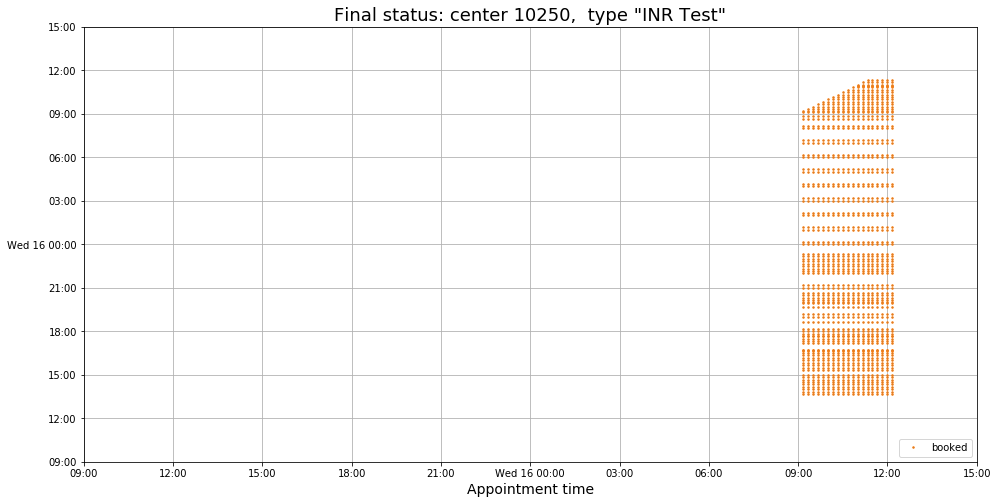

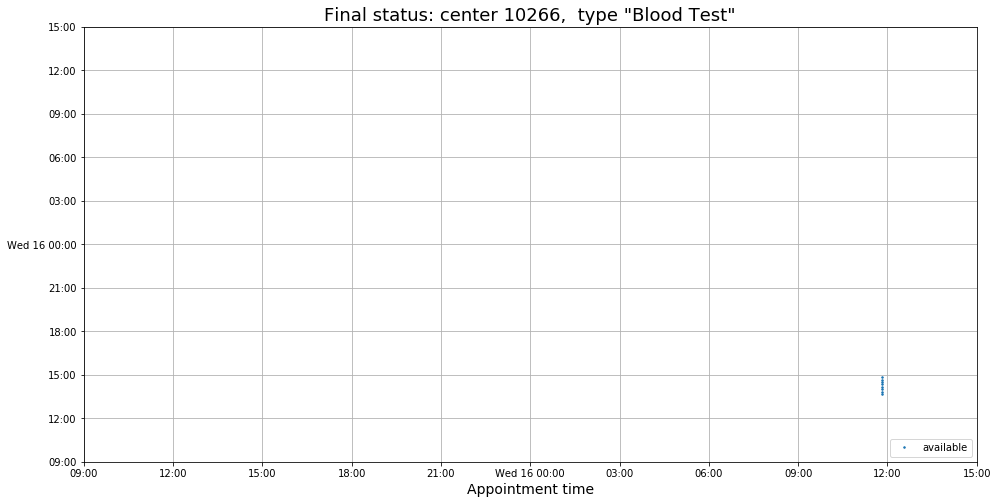

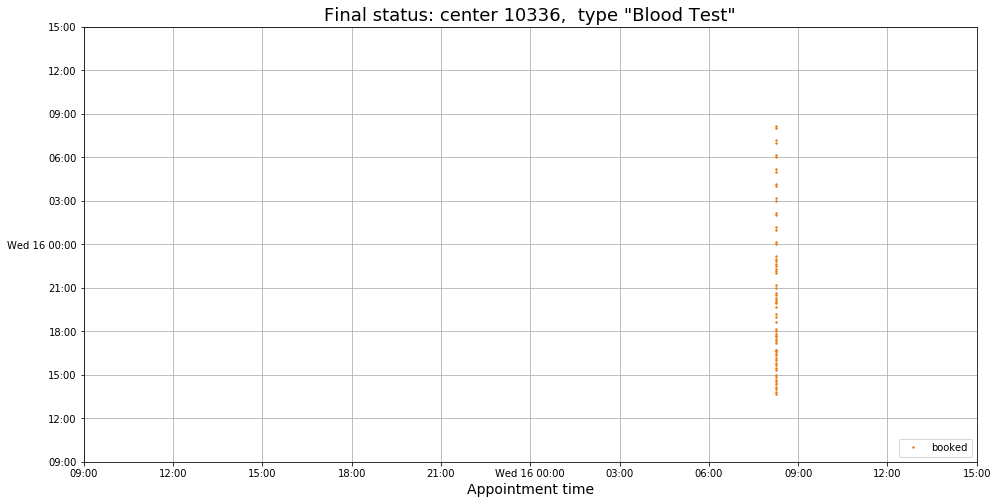

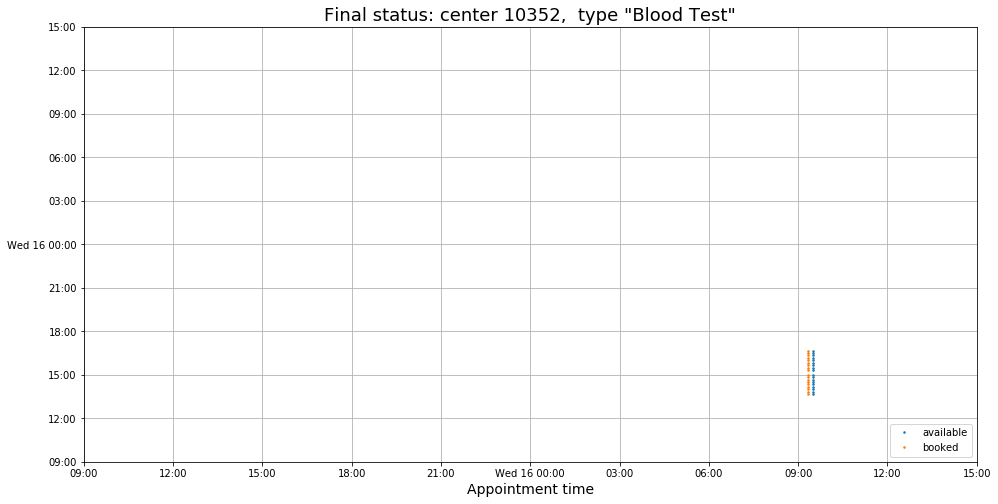

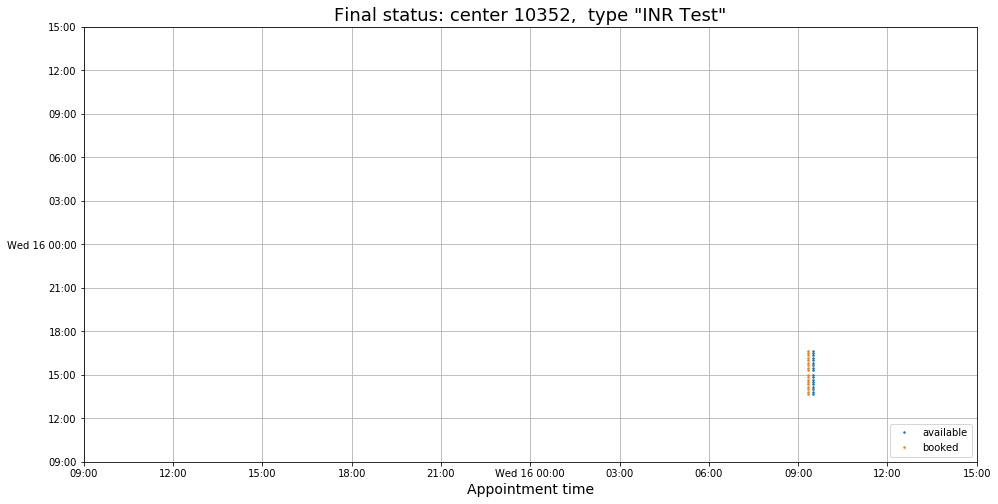

In [16]:
save_figure = False
FIG_SIZE = (16, 8)

COL_WIDTH = 20
VERT_SEP = ": "

if save_figure:
    RUN_DIR = os.path.join(
        IMG_DIR,
        "-".join(
            ["RUN",
             datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")]
        )
    )
    if not os.path.exists(RUN_DIR):
        os.makedirs(RUN_DIR)
    with open(os.path.join(IMG_DIR, 'DESCRIPTION-OF-RUNS.txt'), 'a') as descfile:
        descfile.write("-"*60 + "\n")
        write_line_to_desc("Run", RUN_DIR, descfile)
        write_line_to_desc("Feature", "BOOKING HISTORY", descfile)
        write_line_to_desc("Nb rows", t.shape[0], descfile)

        first_grab = t['grab'].min()
        last_grab = t['grab'].max()
        grab_duration = last_grab - first_grab

        write_line_to_desc("Grab duration", timedelta_strftime(grab_duration), descfile)
        write_line_to_desc("First grab", first_grab, descfile)
        write_line_to_desc("Last grab", last_grab, descfile)

        first_appointment = t['appointment'].min()
        last_appointment= t['appointment'].max()
        appointment_duration = last_appointment - first_appointment

        write_line_to_desc("Appointment duration", timedelta_strftime(appointment_duration), descfile)
        write_line_to_desc("First appointment", first_appointment, descfile)
        write_line_to_desc("Last appointment", last_appointment, descfile)
        
        write_line_to_desc("Figure size", FIG_SIZE, descfile)
        
x_date_range, x_tick_labels = UHCW.get_ticks(t['appointment'], freq='H')
y_date_range, y_tick_labels = UHCW.get_ticks(t['grab'], freq='H')
        


for cid, test_types in center_test_types.iterrows():
    print(cid)
    for test_type in list(test_types)[0]:
        print(test_type)
        t0 = t.loc[(t['id'] == cid) & (t['test type'] == test_type), t.columns]

        if t0.empty:
            print(
                "WARNING: no data for center {0}, {1}".format(
                    cid, test_type
                )
            )
            continue
        else:
            None
        
        fig, ax = plt.subplots(figsize=FIG_SIZE)
        
        legend_text = []
        for status in ['available', 'booked']:
            tt0 = t0.loc[
                t0['final status'] == status,
                ['appointment', 'grab']
            ].drop_duplicates()
            
            if tt0.empty:
                print(
                    'Remark: no data for status "{0}"'.format(
                    status
                    )
                )
                continue
            else:
                None
            
            legend_text.append(status)
            if status == 'available':
                marker_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
            else:
                marker_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
                    
            ax.plot(
                tt0['appointment'],
                tt0['grab'],
                **{'marker': '.', 'markersize': 3, 'markeredgecolor': marker_color, "linestyle": ""}                    
            )
        ax.grid()
        ax.legend(legend_text, loc='lower right')
        ax.set_title('Final status: center {0},  type "{1}"'.format(cid, test_type), fontsize=18);
        ax.set_xlabel("Appointment time", fontsize=14);
        # ax.set_ylabel("Time of visit", fontsize=14);
        ax.set_xticks(x_date_range);
        ax.set_xticklabels(x_tick_labels);
        ax.set_xlim([x_date_range.min(), x_date_range.max()])
        ax.set_yticks(y_date_range);
        ax.set_yticklabels(y_tick_labels);
        ax.set_ylim([y_date_range.min(), y_date_range.max()])
        
        if save_figure:
            plt.savefig(
                os.path.join(
                    RUN_DIR,
                    'center-{0}-{1}-booking-history.png'.format(
                        cid,
                        "-".join(test_type.split())
                    )
                )
            )        

## Visualizing the final status
The **final status** refers to whether an appointment was eventually booked or not.  

Set `save_figure` to **True** to save plots as image files.
In this case, a brief description of the type of figure is appended to `DESCRIPTION-OF-RUNS.txt`.

10136
Non Fasting Bloods
Remark: no data for status "available"
INR Test
Remark: no data for status "available"
10137
Blood Test
Remark: no data for status "booked"
10188
Blood Test
Remark: no data for status "available"
INR Test
10207
Blood Test
Remark: no data for status "available"
10243
Blood Test
INR Test
10244
Blood Test
Remark: no data for status "booked"
INR Test
Remark: no data for status "booked"
10250
Blood Test
Remark: no data for status "available"
INR Test
Remark: no data for status "available"
10254
Blood Test
10266
Blood Test
Remark: no data for status "booked"
10336
Blood Test
Remark: no data for status "available"
10352
Blood Test
INR Test


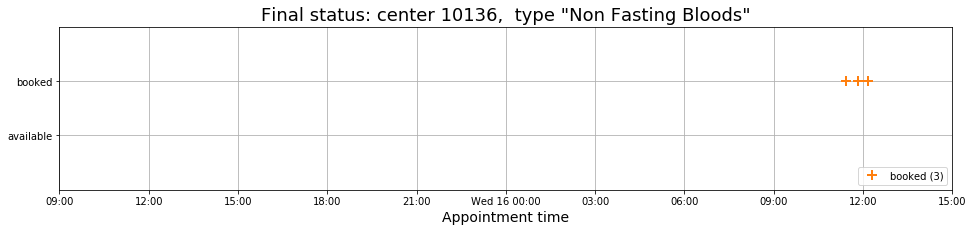

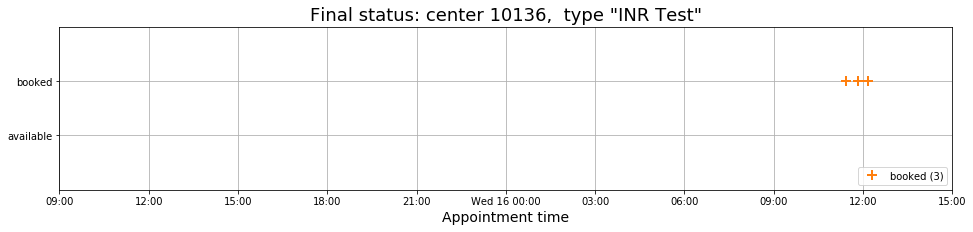

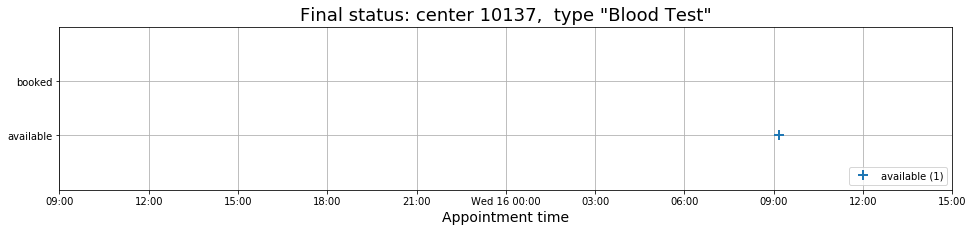

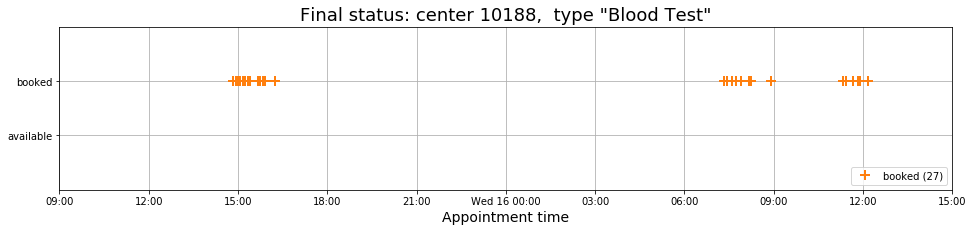

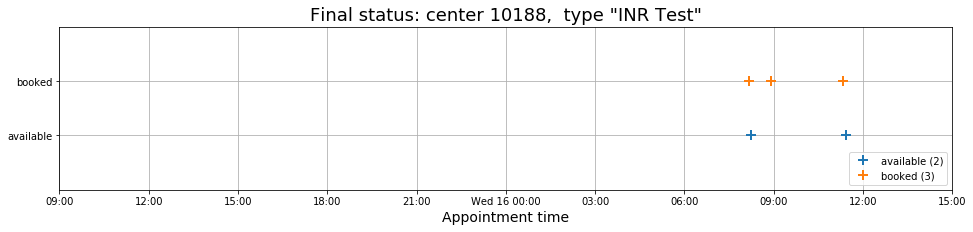

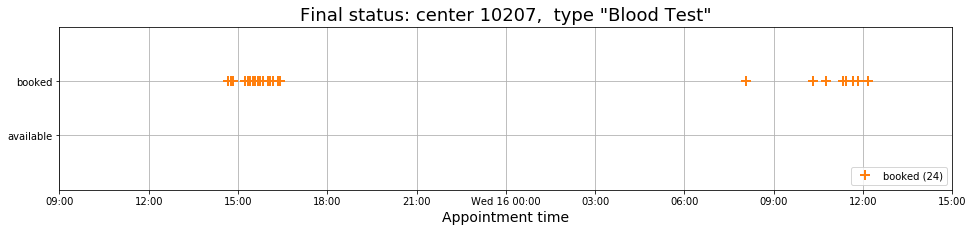

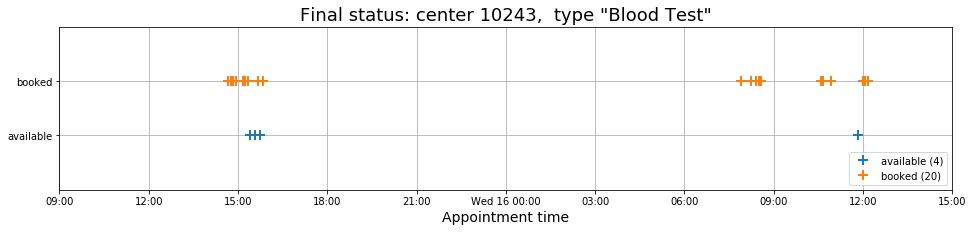

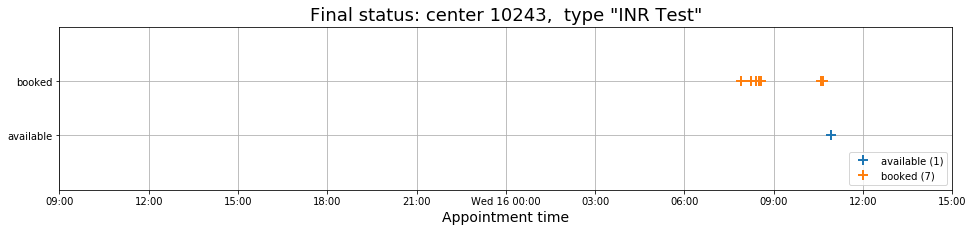

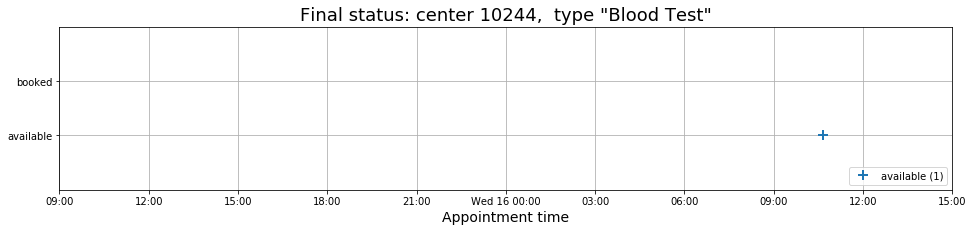

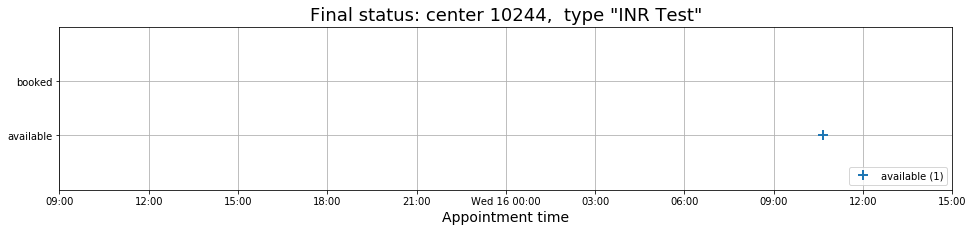

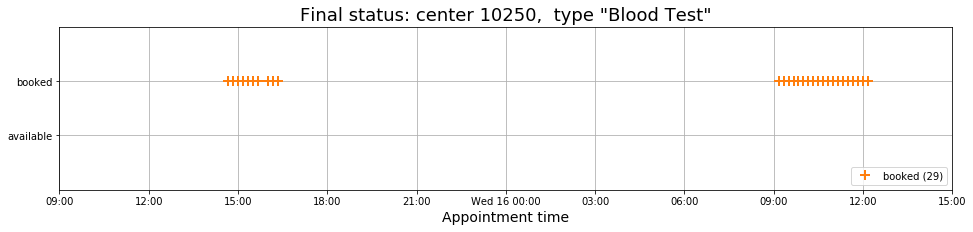

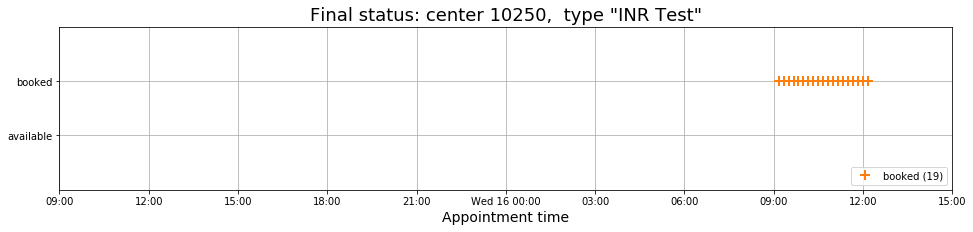

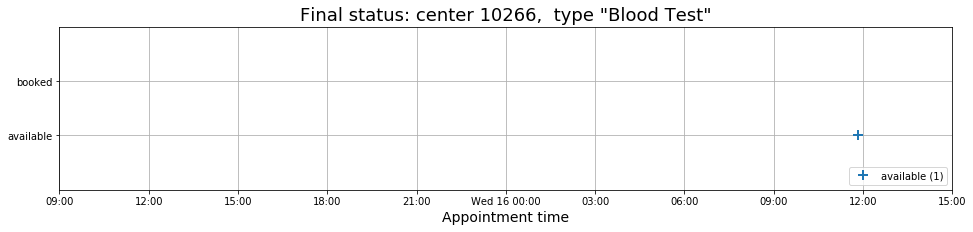

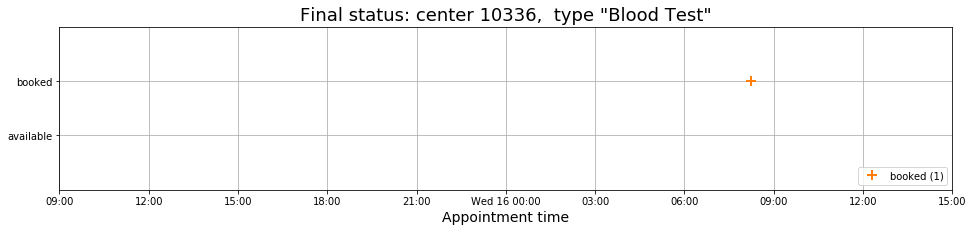

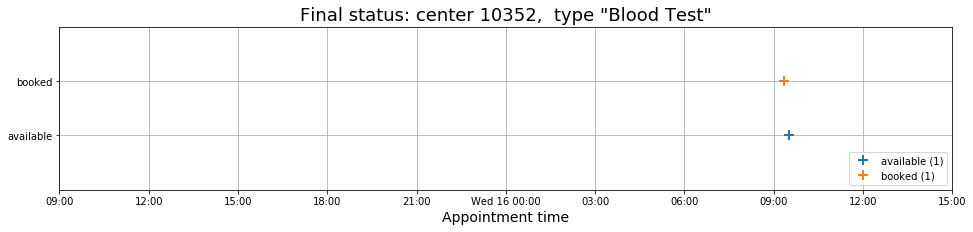

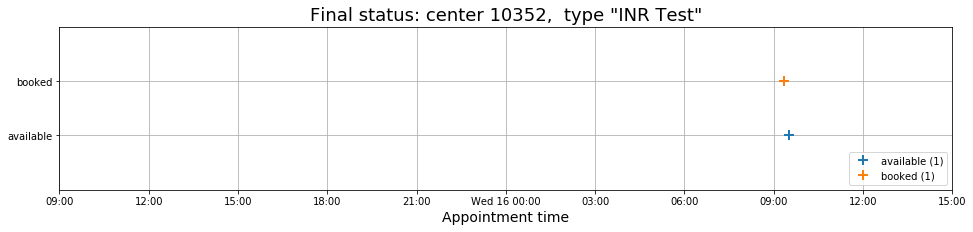

In [17]:
save_figure = False
FIG_SIZE = (16, 3)

COL_WIDTH = 20
VERT_SEP = ": "

if save_figure:
    RUN_DIR = os.path.join(
        IMG_DIR,
        "-".join(
            ["RUN",
             datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")]
        )
    )
    if not os.path.exists(RUN_DIR):
        os.makedirs(RUN_DIR)
    with open(os.path.join(IMG_DIR, 'DESCRIPTION-OF-RUNS.txt'), 'a') as descfile:
        descfile.write("-"*60 + "\n")
        write_line_to_desc("Run", RUN_DIR, descfile)
        write_line_to_desc("Feature", "FINAL STATUS", descfile)
        write_line_to_desc("Nb rows", t.shape[0], descfile)

        first_grab = t['grab'].min()
        last_grab = t['grab'].max()
        grab_duration = last_grab - first_grab

        write_line_to_desc("Grab duration", timedelta_strftime(grab_duration), descfile)
        write_line_to_desc("First grab", first_grab, descfile)
        write_line_to_desc("Last grab", last_grab, descfile)

        first_appointment = t['appointment'].min()
        last_appointment= t['appointment'].max()
        appointment_duration = last_appointment - first_appointment

        write_line_to_desc("Appointment duration", timedelta_strftime(appointment_duration), descfile)
        write_line_to_desc("First appointment", first_appointment, descfile)
        write_line_to_desc("Last appointment", last_appointment, descfile)
        
        write_line_to_desc("Figure size", FIG_SIZE, descfile)

x_date_range, x_tick_labels = UHCW.get_ticks(t['appointment'], freq='H')
# y_date_range, y_tick_labels = UHCW.get_ticks(t['grab'], freq='H')
        


for cid, test_types in center_test_types.iterrows():
    print(cid)
    for test_type in list(test_types)[0]:
        print(test_type)
        t0 = t.loc[(t['id'] == cid) & (t['test type'] == test_type), t.columns]

        if t0.empty:
            print(
                "WARNING: no data for center {0}, {1}".format(
                    cid, test_type
                )
            )
            continue
        else:
            None
        
        fig, ax = plt.subplots(figsize=FIG_SIZE)
        
        legend_text = []
        for status in ['available', 'booked']:
            tt0 = t0.loc[
                t0['final status'] == status,
                ['appointment']
            ].drop_duplicates()
            
            if tt0.empty:
                print(
                    'Remark: no data for status "{0}"'.format(
                    status
                    )
                )
                continue
            else:
                None
            
            legend_text.append(" ".join([status, "({0})".format(tt0.shape[0])]))
            if status == 'available':
                marker_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
            else:
                marker_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
                    
            ax.plot(
                tt0['appointment'],
                [STATUS_TO_VALUE[status]]*tt0.shape[0],
                **{'marker': '+', 'markersize': 10, 'markeredgewidth': 2, 'markeredgecolor': marker_color, "linestyle": ""}                    
            )
        ax.grid()
        ax.legend(legend_text, loc='lower right')
        ax.set_title('Final status: center {0},  type "{1}"'.format(cid, test_type), fontsize=18);
        ax.set_xlabel("Appointment time", fontsize=14);
        # ax.set_ylabel("Time of visit", fontsize=14);
        ax.set_xticks(x_date_range);
        ax.set_xticklabels(x_tick_labels);
        ax.set_yticks([0, 1])
        ax.set_yticklabels(
            [{value: key for key, value in STATUS_TO_VALUE.items()}[idx] for idx in [0, 1]]
        )
        ax.set_ylim([-1, 2])
        ax.set_xlim([x_date_range.min(), x_date_range.max()])

        if save_figure:
            plt.savefig(
                os.path.join(
                    RUN_DIR,
                    'center-{0}-{1}-final-status.png'.format(
                        cid,
                        "-".join(test_type.split())
                    )
                )
            )
            
            

In [18]:
end_script = datetime.datetime.now()

run_time = end_script - beg_script

print("This script ran for: {0}min {1}sec.".format(run_time.seconds//60, run_time.seconds%60))

This script ran for: 4min 41sec.
